In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1

import numpy as np

from utils.utils import get_path
import os
import matplotlib.pyplot as plt

from utils.io_utils import load_multiple_res
from utils.pd_utils import compute_outlier_scores, filter_dgms
from utils.fig_utils import full_dist_to_print, dist_to_color

env: CUDA_VISIBLE_DEVICES=1


In [2]:
style_file = "utils.style"
plt.style.use(style_file)

In [3]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")
dataset = "torus"

In [4]:
# hyperparameters
sigmas = np.linspace(0.0, 0.35, 29) 
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]  #np.arange(3, dtype=int)
nbs = [1000, 5000]
d = 50


distances = {
    "euclidean": [{}],
    "fermat": [
        {"p": 2},
        {"p": 3},
        {"p": 5},
        {"p": 7}
        ],
    "dtm": [
            {"k": 4, "p_dtm": 2, "p_radius": 1},
            {"k": 4, "p_dtm": np.inf, "p_radius": 1},
            {"k": 15, "p_dtm": 2, "p_radius": 1},
            {"k": 15, "p_dtm": np.inf, "p_radius": 1},
            {"k": 100, "p_dtm": 2, "p_radius": 1},
            {"k": 100, "p_dtm": np.inf, "p_radius": 1},
            {"k": 4, "p_dtm": 2, "p_radius": 2},
            {"k": 4, "p_dtm": np.inf, "p_radius": 2},
            {"k": 15, "p_dtm": 2, "p_radius": 2},
            {"k": 15, "p_dtm": np.inf, "p_radius": 2},
            {"k": 100, "p_dtm": 2, "p_radius": 2},
            {"k": 100, "p_dtm": np.inf, "p_radius": 2},
            {"k": 4, "p_dtm": 2, "p_radius": np.inf},
            {"k": 4, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 15, "p_dtm": 2, "p_radius": np.inf},
            {"k": 15, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 100, "p_dtm": 2, "p_radius": np.inf},
            {"k": 100, "p_dtm": np.inf, "p_radius": np.inf},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True,}
    ],
    "diffusion": [
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
}


In [5]:
# load PH results
all_res_50 = {}
for n in nbs:
    all_res_50[n] = load_multiple_res(datasets=dataset, n=n, embd_dims=d, distances=distances, sigmas=sigmas, seeds=seeds, root_path=root_path, n_threads=10)

Done with torus 50 euclidean n_outliers=0, perturbation=None
Done with torus 50 fermat_p_2 n_outliers=0, perturbation=None
Done with torus 50 fermat_p_3 n_outliers=0, perturbation=None
Done with torus 50 fermat_p_5 n_outliers=0, perturbation=None
Done with torus 50 fermat_p_7 n_outliers=0, perturbation=None
Done with torus 50 dtm_k_4_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with torus 50 dtm_k_4_p_dtm_inf_p_radius_1 n_outliers=0, perturbation=None
Done with torus 50 dtm_k_15_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with torus 50 dtm_k_15_p_dtm_inf_p_radius_1 n_outliers=0, perturbation=None
Done with torus 50 dtm_k_100_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with torus 50 dtm_k_100_p_dtm_inf_p_radius_1 n_outliers=0, perturbation=None
Done with torus 50 dtm_k_4_p_dtm_2_p_radius_2 n_outliers=0, perturbation=None
Done with torus 50 dtm_k_4_p_dtm_inf_p_radius_2 n_outliers=0, perturbation=None
Done with torus 50 dtm_k_15_p_dtm_2_p_radius_2 n_outl

In [6]:
# thresholding
dob = 1.25
for n in all_res_50:
    all_res_50[n] = filter_dgms(dgms=all_res_50[n], dob=dob, binary=True, dim=1)

In [7]:
# compute detection scores
outlier_scores = {}
for n in nbs:
    outlier_scores[n] = compute_outlier_scores(all_res_50[n], 
                                            n_features=2, 
                                            dim=1)

In [8]:
# compute area under the curves
aucs = {}

for n in outlier_scores:
    auc_by_n = {}
    for dist in outlier_scores[n]:
        auc_per_method = {}
        for full_dist in outlier_scores[n][dist]:
            auc_per_method[full_dist] = outlier_scores[n][dist][full_dist].mean()
        auc_by_n[dist] = auc_per_method
    aucs[n] = auc_by_n

In [9]:
# Each sample size selects the best method individually.

best_method_per_dataset = {}
for n in aucs:
    best_method_per_n = {}
    for dist in aucs[n]:
        best_full_dist = None
        best_auc = 0
        for full_dist in aucs[n][dist]:
            auc = aucs[n][dist][full_dist]
            if auc > best_auc:
                best_auc = auc
                best_full_dist = full_dist
        best_method_per_n[dist] = best_full_dist
    best_method_per_dataset[n] = best_method_per_n

In [10]:
# print best hyperparameter settings 
for n in best_method_per_dataset:
    print("~"*40)
    print(f"Number of points: {n}")
    
    for dist in best_method_per_dataset[n]:
        print(dist, full_dist_to_print[best_method_per_dataset[n][dist]].replace("\n", " "))
    print("\n")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of points: 1000
euclidean Euclidean
fermat Fermat $p=2$
dtm DTM $k=4, p=2, \xi=\infty$
eff_res Effective resistance $k=100$
diffusion Diffusion $k=15, t=8$


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of points: 5000
euclidean Euclidean
fermat Fermat $p=2$
dtm DTM $k=4, p=\infty, \xi=1$
eff_res Effective resistance $k=100$
diffusion Diffusion $k=100, t=8$




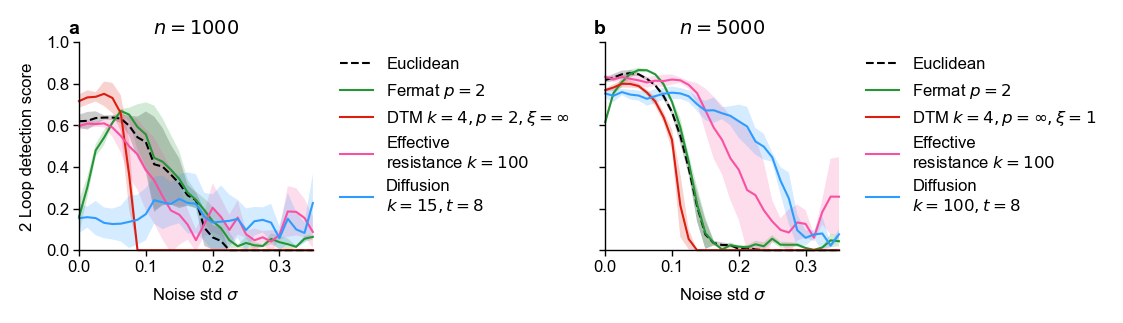

In [11]:
# plot figure
fig, ax = plt.subplots(1, len(nbs), figsize=(5.5, 1.5))
letters = "abcdef"
for i, n in enumerate(nbs):
    for j, dist in enumerate(best_method_per_dataset[n]):
        full_dist = best_method_per_dataset[n][dist]
        #if n == 5000:
        #    mean = outlier_scores[n][dist][full_dist][:,0] 
        #    std = outlier_scores[n][dist][full_dist][:, 0][:, None].std(1)
        #else:
        mean = outlier_scores[n][dist][full_dist].mean(1)
        std = outlier_scores[n][dist][full_dist].std(1)
        
        if dist == "euclidean":
            linestyle = "dashed"
        else:
            linestyle = "solid"
        
        ax[i].plot(sigmas, 
                   mean,
                   label=full_dist_to_print[full_dist],
                   color=dist_to_color[dist],
                   linestyle=linestyle,
                   clip_on=False)
        ax[i].fill_between(
            sigmas,
            mean - std,
            mean + std,
            alpha=0.2,
            color=dist_to_color[dist],
            edgecolor=None,
        )
            
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, sigmas.max())
    ax[i].set_xlabel("Noise std $\sigma$")
    ax[i].set_title(f"$n={n}$")
    
    ax[i].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
)

for i in range(2):
    #ax[i].legend(loc="upper left", bbox_to_anchor=(0.25, -0.2))
    ax[i].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0))
    if i == 0:
        ax[i].set_ylabel("2 Loop detection score")
    else:
        ax[i].set_yticklabels([])
fig.savefig(os.path.join(fig_path, "torus_vary_n.pdf"))